# RAW NOTES

### Profit estimation


#### Product margin

Unfortunately, margin on user-item transaction are omitted in the available datasets. To include the profit aspect of the customer relationship management, we propose simulation approach describing changes in product margin over time, which are consequently used for estimating customer profit. That is, for each of the product, we draw from initial random normal distribution. This draw serves as a starting point for the random walk, which we simulate using draws from random normal distribution for step difference and put them together using cumulative sum. In other words, we use one dimensional random walk with random normal steps. For product *p* in time *t*, we estimate the margin *m* like this:
   
$$m^{p}_t = Normal(\mu_0, \sigma_0)+\sum^{t}_{n=1}{Normal(\mu_{diff}, \sigma_{diff})}$$

where the first element represents the starting draw, and the second element represents the cumulative sum of difference draws. For simplicity, we assume that initial variability across products and variability of the product, within the observed period, are the same. Thus, we set \\(\mu_{diff} = 0\\), and \\(\sigma_{diff}=\frac{\sigma_0}{\sqrt{t}}\\).  As a result, we are able to estimate product profit with respect to just parameters of the initial random draw \\(\mu_{0}\\) and \\(\sigma_{0}\\).

#### Customer profit

The customer profit is computed using product revenue and simulated margin, result is scaled to reflect the target window size. This approach allows us to differentiate customer profit on individual level, indicate changes in customer behavior (partial churn), and can be used as secondary target for modeling. On the other hand, it is fairly limited by the window size and does not reflect on lifecycle length such as CLV. Let as have a customer \\(i\\) at time \\(t\\), the average customer profit can be computed as

$$ ACP^{i}_t = \frac{n_t}{t}\sum^{t}_{n=1}{m^{p}_n  r^{p}_n} $$

where \\(n_t\\) represent the length of the target window, \\(m^{p}_n\\) stands for simulated margin for product \\(p\\) in the time \\(n\\), and \\(r^{p}_n\\) is the revenue from transaction realized on product \\(p\\) in the time \\(n\\).

NOTE: INCLUDE TIME AXIS, REFERENCE OTHER APPROACHES

#### Plotting


* AVGCP VS TIME
* AVGCP DISTRIBUTION
* vs BOTH DATASETS

#### Sensitivity analysis

 * AVGCP VS mu0, sigma
 * vs BOTH DATASETS
 

### Expected campaign profit

The classical approach to retention management is to identify the customers at high risk of churning and persuade them to stay active with promotional offers. Predictive solutions are, however, primarily evaluated in terms of the classification task, not in the retention management context. To reflect on those additional steps, we propose an evaluation procedure inspired by the retention campaign (Neslin et al., 2006) and generated profit frameworks (Tamaddoni et al., 2015).

However, we focus on differentiated customer value and 


$$ \pi_i = p_i[\gamma_i V_i (1-\delta_i)] + (1-p_i)[-\psi_i \delta_i]$$

### Maximum expected campaign profit

In [1]:
def simulate_margin(products, dates, loc, scale):
    import numpy as np
    import pandas as pd

    n_products = len(products)
    n_days = len(dates)    

    scale_diff = scale/np.sqrt(n_days)
    product_baseline = np.random.normal(loc=loc,scale=scale,size=(n_products,1))
    product_diff = np.random.normal(loc=0, scale=scale_diff, size=(n_products, n_days-1))
    margins = np.cumsum(np.concatenate([product_baseline, product_diff], axis=1), axis=1)
    margins = pd.DataFrame(margins, columns=dates)
    margins["product_id"] = products
    return margins

def plot_simulated_data(data, setup):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt


    x, y, hue = setup["x"], setup["y"], setup["hue"]
    labs = setup["labs"]
    fig, axs = plt.subplots(1,2, figsize=(20,7.5))
    # walk
    sns.lineplot(data=data,
        x=x, y=y, hue=hue,
        legend=False, palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5, ax=axs[0]);
    axs[0].set_ylabel(labs["y"]);
    axs[0].tick_params(axis='x', rotation=90);
    axs[0].set_xlabel(labs["x"]);
    # hist
    sns.histplot(data=data,
        x=y, bins=50,
        color=sns.color_palette("rocket",10)[1],
        ax=axs[1]);
    axs[1].set_ylabel("frequency");
    axs[1].set_xlabel(labs["y"]);

def get_purchases(path="../data/raw/retailrocket/events"):
    import numpy as np
    import pandas as pd

    events = pd.read_parquet(path).drop_duplicates()
    purchases = events[events.event_type_name=="purchase"]
    purchases.loc[:,"date"] = purchases.event_time.dt.date
    purchases["week_start"] = purchases["date"] -\
        pd.to_timedelta(purchases["event_time"].dt.dayofweek, unit="d")
    return purchases    

def get_acp(purchases, margins, target_size=4):
    import pandas as pd
    from itertools import product

    purchases = purchases.merge(margins, on=["product_id","date"], how="inner")
    purchases["profit"] = purchases.revenue*purchases.margin
    purchases = purchases.groupby(["user_id", "week_start"], as_index=False)\
        .agg(profit=("profit", sum), revenue=("revenue", sum))
    user_week_product = product(purchases.user_id.unique(), purchases.week_start.unique())
    user_acp = pd.DataFrame(user_week_product, columns=["user_id", "week_start"])\
        .merge(purchases, on=["user_id", "week_start"], how="left")\
            .fillna(0).sort_values("week_start")\
                .rename(columns={"week_start":"date"})
    user_acp["acp"] = target_size*user_acp.groupby("user_id").profit.cumsum()/\
        (user_acp.groupby("user_id").cumcount()+1)
    return user_acp.loc[:,["user_id", "date", "acp"]]

#NOTE: CLEAN UP LOC FROM NAMING - CLASHING WITH THE METHODS WHEN USING DOTS
def simulate_acp(purchases, loc, scale, seed=0):
    import numpy as np
    import pandas as pd
    
    np.random.seed(seed)
    dates = purchases.sort_values("week_start").week_start.unique()
    products = purchases.product_id.unique()
    margins = simulate_margin(products, dates, loc, scale)
    margins = pd.melt(margins, id_vars=["product_id"],
            var_name="date", value_name="margin")
    user_acp = get_acp(purchases, margins, 4)
    #return pd.DataFrame([[loc, scale, seed, user_acp.acp.mean(), user_acp.acp.std()]],
    #    columns=["loc","scale", "seed", "mu", "sigma"])        
    user_acp["loc"] = loc
    user_acp["scale"] = scale
    user_acp["seed"] = seed
    return user_acp

### Simulate margin & estimate ACP

/tmp/ipykernel_230/3858961302.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:,"date"] = purchases.event_time.dt.date
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(
/tmp/ipykernel_230/3858961302.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases["week_start"] = purchases["date"] -\


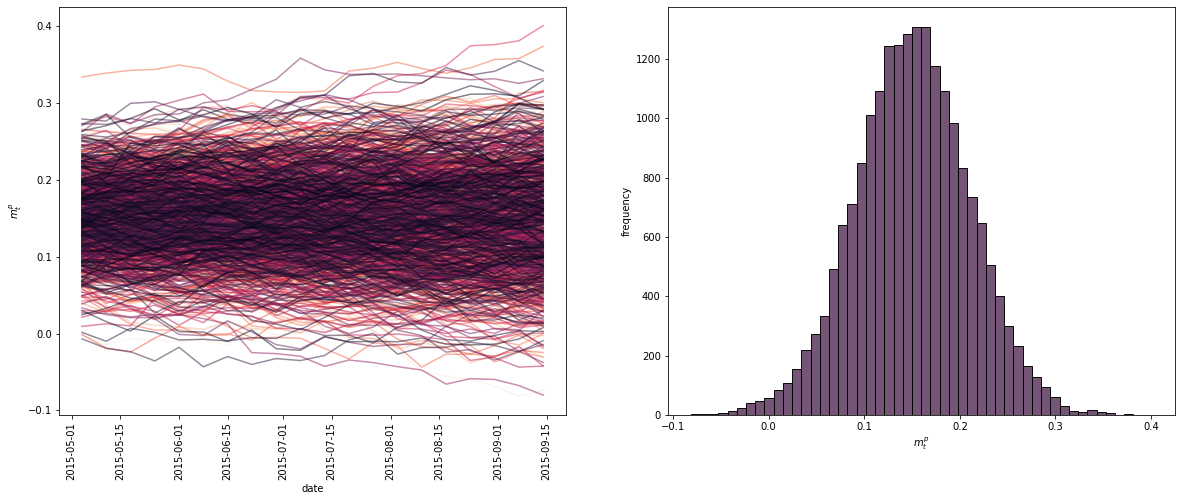

In [2]:
# SIMULATE MARGINS
import pandas as pd
purchases = get_purchases()
# simulation
loc = 0.15
scale = 0.05
dates = purchases.sort_values("week_start").week_start.unique()
products = purchases.product_id.unique()
margins = simulate_margin(products, dates, loc, scale)
margins = pd.melt(margins, id_vars=["product_id"],
        var_name="date", value_name="margin")
# plot
prod_subset = margins.product_id.isin(margins.product_id.unique()[:1000])
plot_conf = {"x":"date", "y":"margin", "hue":"product_id", "labs":{"x":"date", "y":"$m^p_t$"}}    
plot_simulated_data(margins[prod_subset], plot_conf)

DescribeResult(nobs=3401, minmax=(0.0, 563938.5106477729), mean=20927.143865692236, variance=2480411108.880008, skewness=4.278885425484817, kurtosis=23.94706905498073)

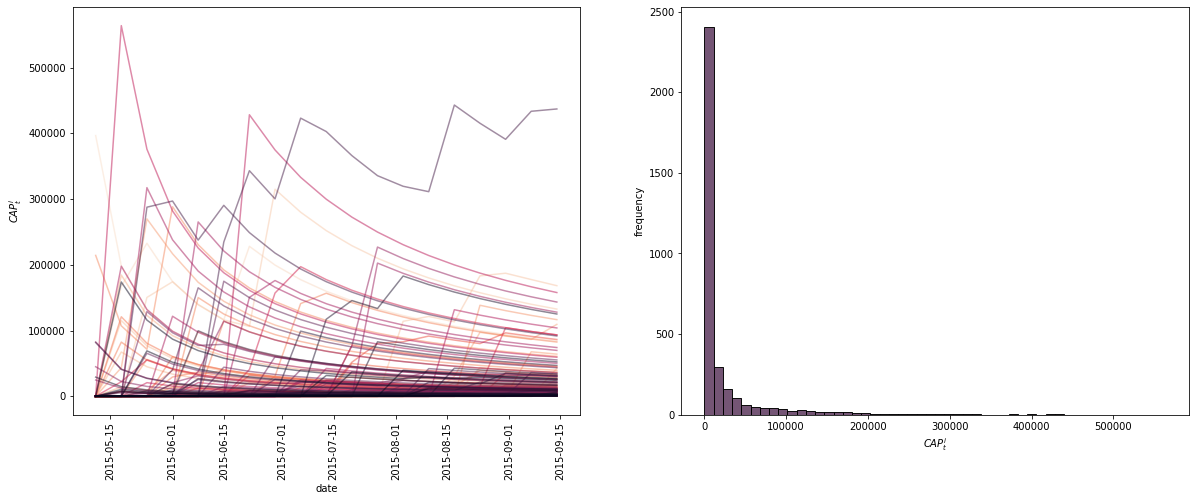

In [3]:
user_acp =  get_acp(purchases, margins, target_size=4)
plot_conf = {"x":"date", "y":"acp", "hue":"user_id", "labs":{"x":"date", "y":"$CAP^i_t$"}} 
plot_simulated_data(user_acp, plot_conf)
from scipy.stats import describe
describe(user_acp.acp)

### Sensitivity analysis

In [4]:
from itertools import product
import numpy as np

mu_range = [0.05,0.15,0.25]
sigma_range = [0.05, 0.1, 0.15]
seed_range = np.random.randint(low=0, high=2**16, size=100)

def para_sacp(params):
    return simulate_acp(purchases,
        params[0], params[1], params[2])

def get_sim_stats(df):
    import numpy as np
    from scipy import stats

    loc = df["loc"].unique()[0]
    scale = df["scale"].unique()[0]
    mu =  df["acp"].mean()
    lb, ub =  np.percentile(df["acp"], q=[2.5, 97.5])
    ads = stats.describe(df["acp"])
    return pd.DataFrame([[loc, scale, mu, lb, ub, ads]], columns=["loc","scale","mu","lb","ub","summary"])

In [5]:
# simulate
from multiprocessing import Pool
with Pool(4) as poo:
    sensitivity_simulation = poo.map(para_sacp,
        product(mu_range, sigma_range, seed_range))
sensitivity_simulation =  pd.concat(sensitivity_simulation)
# get stats    
sensitivity_summary = sensitivity_simulation.groupby(
    ["loc","scale"], as_index=False).apply(get_sim_stats)
sensitivity_summary

,,loc,scale,mu,lb,ub,summary
0,0,0.05,0.05,6776.429957,-1310.292158,58096.337315,"(340100, (-141821.52002832788, 337518.03002390..."
1,0,0.05,0.10,6674.509593,-10314.364671,68060.877854,"(340100, (-392192.6400566559, 524852.650297241..."
2,0,0.05,0.15,6572.589229,-22540.301048,80132.995995,"(340100, (-642563.7600849837, 733004.175445862..."
3,0,0.15,0.05,20533.130598,0.000000,161936.207842,"(340100, (-43961.63003646177, 710526.030023900..."
4,0,0.15,0.10,20431.210235,-184.028544,166412.130755,"(340100, (-218783.26007292353, 861540.06004780..."
5,0,0.15,0.15,20329.289871,-3930.876475,174289.011944,"(340100, (-425464.5600849836, 1012554.09007170..."
6,0,0.25,0.05,34289.831240,0.000000,269001.719095,"(340100, (0.0, 1083534.0300239006), 34289.8312..."
7,0,0.25,0.10,34187.910876,0.000000,270668.392260,"(340100, (-131543.26007292353, 1234548.0600478..."
8,0,0.25,0.15,34085.990512,0.000000,275609.770725,"(340100, (-306364.89010938525, 1385562.0900717..."


### Maximum expected campaign profit

In [6]:
# DEVELOP TOY EXAMPLE FOR THE PROFIT SIM AND EVAL


### EVAL FUNC1

# INPUTS
# p - probability of churning
# gamma - probability of accepting the retention offer, with previous intetion to churn
# ACP - average customer's profit 
# delta - cost of the retention offer - fixed, due to practicality (one campaign)
# psi - probability of accepting the retention offer, with previous intetion to stay

# OUTPUTS
# profit per each customer
def expected_campaign_profit(p_churn, p_gamma, acp, delta, p_psi):
    return p_churn*p_gamma*(acp-delta)+(1-p_churn)*(-p_psi*delta)

### EVAL FUNC2
def maximum_expected_campaign_profit(exp_camp_profit):
    import numpy as np
    
    cecp = exp_camp_profit.cumsum()
    perc = cecp.rank(perc=True)
    max_ind = np.argmax(cecp)
    return (cecp[max_ind], perc[max_ind])

In [7]:

### we have to simulate the args


# alpha-beta combination for gamma
# alpha-beta combination for psi
# 10 % from median transaction





In [8]:
purchases = purchases.merge(margins, on=["product_id","date"], how="inner")
purchases["profit"] = purchases.margin*purchases.revenue


user_id
8043        6538.217920
8411        1949.017215
11333       2673.333634
17676       6452.279509
29802      16200.668095
               ...     
1378697     5602.215110
1385073    14090.689037
1398811     1071.958992
1403769    27197.269704
1406087     4365.701361
Name: profit, Length: 179, dtype: float64

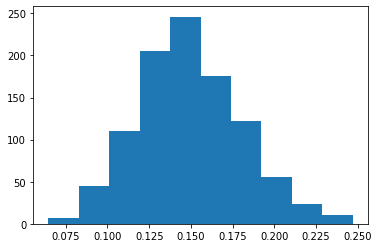

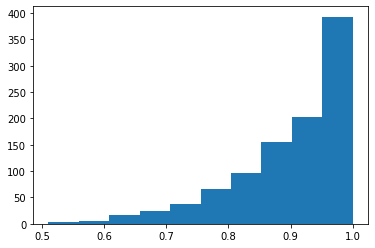

In [100]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(np.random.beta(20.05, 113.616, size=1000));
fig = plt.figure()
plt.hist(np.random.beta(9, 1, size=1000));